In [1]:
import h5py, os, pickle
from importlib import reload
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib import cm
from imp import reload

from ecog.utils import bands
from cv_paper_plots.style import (subject_colors, letter_fontstyle,
                                  ticklabel_fontstyle, subject_labels)

import scipy as sp
from cv_paper_plots import xfreq_analysis as xfa
from cv_paper_plots import broadband
from cv_paper_plots.xfreq_analysis import good_examples_and_channels
from cv_paper_plots.broadband import (forward_bl, invert_bl, new_ch_idx, get_pcs, flip,
                                      baseline_mean_std, plot_PC1s, load_data)

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

/home/jesse/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Load data

In [2]:
folder = os.path.join(os.environ['HOME'],'Development/data/ecog/AA_ff/')
subjects = ['ec2', 'ec9', 'gp31', 'gp33']
files = ['EC2_blocks_1_8_9_15_76_89_105_CV_AA_ff_align_window_-0.5_to_0.79_none.h5',
         'EC9_blocks_15_39_46_49_53_60_63_CV_AA_ff_align_window_-0.5_to_0.79_none.h5',
         'GP31_blocks_1_2_4_6_9_21_63_65_67_69_71_78_82_83_CV_AA_ff_align_window_-0.5_to_0.79_none.h5',
         'GP33_blocks_1_5_30_CV_AA_ff_align_window_-0.5_to_0.79_none.h5']
freqs = bands.chang_lab['cfs']
cfs = bands.chang_lab['cfs']

In [3]:
subject_idx = 0
subject = subjects[subject_idx]

In [4]:
fname = os.path.join(folder, files[subject_idx])
X, baselines, good_examples, good_channels, tokens, block_labels, labels = load_data(fname)
bl_mean, bl_std = baseline_mean_std(block_labels, good_channels, baselines)
print(subject)
X.min(), X.max()

2572 86
ec2


(9.888741e-09, 0.040291335)

In [5]:
X[X <= 0.] = X[X > 0.].min()

In [6]:
bl_type = 'bl_zscore'
Xp = X.copy()
Xp, bl_type_mean = forward_bl(Xp, bl_type, bl_mean, bl_std, block_labels)

# Power spectra

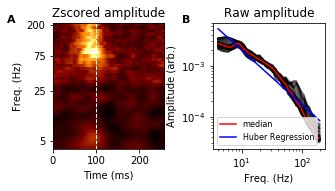

In [7]:
f = plt.figure(figsize=(4.5, 2.5))
top = .1
bot = .2
left = .15
right = .01
h_gap = .15
height = 1. - top - bot
width = (1. - left - right - h_gap) / 2.
ax0 = f.add_axes([left, bot, width, height])
ax1 = f.add_axes([left+width+h_gap, bot, width, height])

cv = np.where(np.array(tokens) == 'gaa')[0]
ch = 103
x = np.tile(bands.chang_lab['cfs'][:, np.newaxis], (1, 258))
y = X[:, labels==cv, new_ch_idx(ch, good_channels)].mean(axis=1)
yp = Xp[:, labels==cv, new_ch_idx(ch, good_channels)].mean(axis=1)

im = ax0.imshow(yp[::-1], interpolation='nearest', cmap='afmhot',
                        aspect='auto')
yticklabels = [5, 25, 75]
yticks = [40-np.searchsorted(bands.chang_lab['cfs'], y, side='right') for y in
          yticklabels]
yticklabels.append(200)
yticks.append(0)
ax0.set_yticks(yticks)
ax0.set_yticklabels(yticklabels)
ax0.set_title('Zscored amplitude')
ax0.set_ylabel('Freq. (Hz)')
ax0.set_xlabel('Time (ms)')
ax0.axvline(100, 0, 1, linestyle='--', c='white', lw=1.)

ax1.plot(x, y, c='k', alpha=.1)
ax1.plot(x[:, 0], np.median(y, axis=1), c='red', label='median')
m, b, R2 = broadband.log_log_robust_regression(freqs, y)
yp = broadband.calc_bb_estimate(freqs, m, b)
ax1.plot(x[:, 0], yp, c='blue', label='Huber Regression')
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_ylabel('Amplitude (arb.)')
ax1.set_xlabel('Freq. (Hz)')
ax1.set_title('Raw amplitude')
ax1.legend(loc='best', fontsize=8)

f.text(.01, .9, 'A', size=11, fontweight='bold')
f.text(.55, .9, 'B', size=11, fontweight='bold')

plt.savefig(os.path.join(os.environ['HOME'], 'Downloads/{}_spects.pdf'.format(subject)), dpi=300)
plt.savefig(os.path.join(os.environ['HOME'], 'Downloads/{}_spects.png'.format(subject)), dpi=300)

# PCA

# P1

In [8]:
bl_type = 'data_mean'

def plot_PC1s(pcs, evs, mean, ax0, title=False, ylabel=None):
    if pcs.ndim > 3:
        pcs = pcs.reshape(-1, 3, 40)
        mean = mean.reshape(-1, 40)
        evs = evs.reshape(-1, 3)
    freqs = bands.chang_lab['cfs']
    ratios = evs[:, 1:]/evs[:, [0]]
    beta_weights = np.zeros(pcs.shape[0])
    beta_weights = (pcs[:, 0, 14:20]).sum(axis=-1)
    beta_weights -= beta_weights.min()
    beta_weights /= beta_weights.max()
    for ii, pc in enumerate(pcs):
        ax0.plot(freqs, pcs[ii, 0],c=cm.Greys(beta_weights[ii]), alpha=1.)
    ax0.plot(freqs, np.median(pcs[:, 0], axis=0), c='r')
    ax0.axhline(0, 0, 1, c='blue', ls='--')
    if ylabel is not None:
        ax0.set_ylabel(ylabel)
    return

(2, 86, 3, 40)
(2, 78, 3, 40)
(2, 83, 3, 40)
(2, 99, 3, 40)


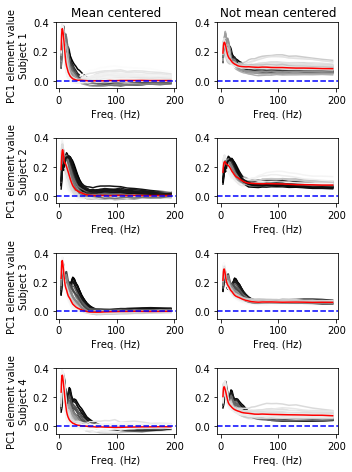

In [9]:
reload(broadband)
f, axes = plt.subplots(4, 2, figsize=(5, 8*5/6.))
for ii, s in enumerate(subjects):
    d = np.load('{}_pca_analysis_{}.npz'.format(s, bl_type))

    ax0 = axes[ii, 0]
    pcs = d['pcs']
    print(pcs.shape)
    evs = d['evs']
    means = d['means']
    plot_PC1s(pcs[0], evs[0], means[0], ax0)
    ax0.set_ylabel('PC1 element value\n{}'.format(subject_labels[s]))
    
    ax1 = axes[ii, 1]
    plot_PC1s(pcs[1], evs[1], means[1], ax1)
    ax0.set_ylabel('PC1 element value\n{}'.format(subject_labels[s]))

for ax in axes.ravel():
    ax.set_xlabel('Freq. (Hz)')
    ax.set_ylim(-.05, .4)
    
axes[0, 0].set_title('Mean centered')
axes[0, 1].set_title('Not mean centered')

f.tight_layout()
plt.savefig(os.path.join(os.environ['HOME'], 'Downloads/PC1s_{}_both.pdf'.format(bl_type)))

/home/jesse/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  patch = ax.patch


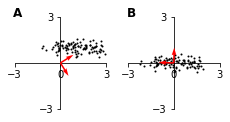

In [136]:
f = plt.figure(figsize=(3, 1.5))
le = .03
re = .07
te = .1
be = .05

h_gap = .1
width = (1. - le - re - h_g) / 2.
height = 1. - te - be

ax0 = f.add_axes([le, be, width, height])
ax1 = f.add_axes([le + width + h_gap, be, width, height])
axes = [ax0, ax1]

x = np.stack([np.random.randn(100) * 1, np.random.randn(100) * .25])

x = x + 1.
ax0.scatter(*x, c='k', marker='.', s=4)
u, s, vh = np.linalg.svd(x)
u *= np.sign(u[0])
ax0.quiver(np.zeros(2), np.zeros(2), u[0], u[1],
           units='xy', angles='xy', scale=1., scale_units='xy',
           width=.1, color='r', zorder=10)

x = x - 1
ax1.scatter(*x, c='k', marker='.', s=4)
u, s, vh = np.linalg.svd(x)
ax1.quiver(np.zeros(2), np.zeros(2), u[0], u[1],
           units='xy', angles='xy', scale=1., scale_units='xy',
           width=.1, color='r', zorder=10)

for ax in axes:
    ax.set_xlim(-3, 3)
    ax.set_xticks([-3, 0, 3])
    ax.set_ylim(-3, 3)
    ax.set_yticks([-3, 3])
    ax.spines['left'].set_position('center')
    ax.spines['bottom'].set_position('center')

    # Eliminate upper and right axes
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')

    # Show ticks in the left and lower axes only
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

f.text(.025, .9, 'A', size=12, fontweight='bold')
f.text(.55, .9, 'B', size=12, fontweight='bold')
f.tight_layout()
plt.savefig('/home/jesse/Downloads/center_pca.pdf')

In [96]:
u.shape

(2, 2)

In [97]:
vh.shape

(100, 100)

In [98]:
u

array([[-0.99889278,  0.04704474],
       [ 0.04704474,  0.99889278]])

# 1/f

In [10]:
beta, hg = xfa.extract_b_hg(X)
d = np.load('{}_bb.npz'.format(subject))
X_fits = d['X_bls']
X_medR2 = d['X_medR2']
kind = d['kind']
P_bl = broadband.calc_bb_estimate(cfs, X_fits[..., 0], X_fits[..., 1])
P_bl_beta, P_bl_hg = xfa.extract_b_hg(P_bl)

In [11]:
ccs_bb_hg = broadband.correlate_ts(hg.mean(axis=0), P_bl_hg.mean(axis=0))
ccs_beta_beta_u = broadband.correlate_ts((beta-P_bl_beta).mean(axis=0), beta.mean(axis=0))

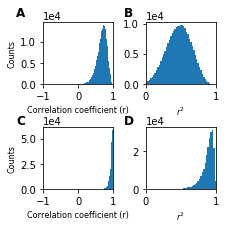

In [12]:
f = plt.figure(figsize=(3, 3))

top = .275
bot = .15
left = .175
right = .175
h_gap = .15
v_gap = .2
width = (1. - left - right) / 2.
height = (1. - top - bot) / 2.

ax0 = f.add_axes([left, bot+height+v_gap, width, height])
ax1 = f.add_axes([left+width+h_gap, bot+height+v_gap, width, height])
ax2 = f.add_axes([left, bot, width, height])
ax3 = f.add_axes([left+width+h_gap, bot, width, height])

ax0.hist(ccs_bb_hg.ravel(), bins=np.linspace(-1, 1, 100))
ax0.set_xlabel('Correlation coefficient (r)', size=8)
ax0.set_ylabel('Counts', size=8)
ax0.set_xlim(-1, 1)
ax0.set_xticks([-1, 0, 1])

ax1.hist(ccs_bb_hg.ravel()**2, bins=np.linspace(0, 1, 50))
ax1.set_xlabel(r'$r^2$', size=8)
ax1.set_xlim(0, 1)
ax1.set_xticks([0, 1])

ax2.hist(ccs_beta_beta_u.ravel(), bins=np.linspace(-1, 1, 100))
ax2.set_xlabel('Correlation coefficient (r)', size=8)
ax2.set_ylabel('Counts', size=8)
ax2.set_xlim(-1, 1)
ax2.set_xticks([-1, 0, 1])

ax3.hist(ccs_beta_beta_u.ravel()**2, bins=np.linspace(0, 1, 50))
ax3.set_xlabel(r'$r^2$', size=8)
ax3.set_xlim(0, 1)
ax3.set_xticks([0, 1])

for ax in [ax0, ax1, ax2, ax3]:
    ax.ticklabel_format(axis='y', style='sci', scilimits=[0, 1])
    
f.text(.05, .95, 'A', size=12, fontweight='bold')
f.text(.55, .95, 'B', size=12, fontweight='bold')
f.text(.05, .45, 'C', size=12, fontweight='bold')
f.text(.55, .45, 'D', size=12, fontweight='bold')
    
plt.savefig(os.path.join(os.environ['HOME'], 'Downloads/correlations_{}.pdf'.format(subject)))

In [20]:
X[:] = np.log(X)
X -= np.log(broadband.calc_bb_estimate(cfs, X_fits[..., 0], X_fits[..., 1]))

In [21]:
t = np.linspace(-500, 790, X.shape[-1])
meds_b = np.zeros((40, t.size))
for ii in range(40):
    for jj in range(t.size):
        meds_b[ii, jj] = np.median(X[ii, ..., jj])

meds_t = np.zeros(t.size)
for ii in range(t.size):
    meds_t[ii] = np.median(X[..., ii])
    
meds = np.zeros(40)
for ii in range(40):
    meds[ii] = np.median(X[ii])

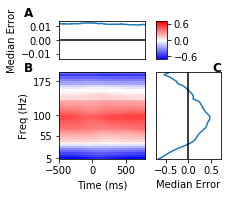

In [79]:
def plot_errors(x, errors, ax, xlabel, title=None):
    ax.plot(x, errors)
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    ax.set_ylabel('Median Error')
    if title is not None:
        ax.set_title(title)
    ax.axhline(0, 0, 1, c='k')
    m = abs(errors).max() * 1.1
    ax.set_ylim(-m, m)
    ax.set_xlim(x[0], x[-1])

def plot_errors2(x, errors, ax, ylabel, title=None):
    x = np.arange(x.size)
    ax.plot(errors, x)
    if ylabel is not None:
        ax.set_ylabel(ylabel)
    ax.set_xlabel('Median Error')
    if title is not None:
        ax.set_title(title)
    ax.axvline(0, 0, 1, c='k')
    m = abs(errors).max() * 1.1
    ax.set_xlim(-m, m)
    ax.set_ylim(x[0], x[-1])

figsize = (3, 2.5)
f = plt.figure(figsize=figsize)
le = .24
re = .01
te = .075
be = .16
s_w = .4
s_h = s_w * figsize[0] / figsize[1]
v_g = .075
h_g = .05
cw = .05

ax0 = f.add_axes([le, be, s_w, s_h])

m = abs(meds_b).max()
im = ax0.imshow(meds_b[::-1], extent=[-500, 790, cfs[0], cfs[-1]], cmap='bwr', vmin=-m, vmax=m, aspect='auto')
ax0.set_yticks([5, 55, 100, 175]) #np.linspace(cfs[0], cfs[-1], 40)[::4])
#ax0.set_yticklabels(np.around(cfs, 1)[::4])
ax0.set_xlabel('Time (ms)')
ax0.set_ylabel('Freq (Hz)')

x1 = le + s_w + h_g
y1 = be + s_h + v_g
ax1 = f.add_axes([le, y1, s_w, 1 - (y1 + te) ])
ax2 = f.add_axes([x1, be, 1 - (x1 + re), s_h ])
cax = f.add_axes([le + s_w + h_g, y1, cw, 1 - (y1 + te)])

cbar = f.colorbar(im, cax, ticks=[-.6, 0, .6])
plot_errors(t, meds_t, ax1, None)
plot_errors2(cfs, meds, ax2, None)
ax1.set_xticks([])
ax2.set_yticks([])

f.text(.08, .95, 'A', size=12, fontweight='bold')
f.text(.08, .645, 'B', size=12, fontweight='bold')
f.text(.95, .645, 'C', size=12, fontweight='bold')

plt.savefig('/home/jesse/Downloads/time_freq_heat.pdf')